In [1]:
import cv2
import numpy as np
import time
from skimage.transform import pyramid_gaussian
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def rgb2yiq(img):
    transform_matrix = np.array([
        [.299, .587, .114],
        [.596, -.274, -.322],
        [.211, -.523, .312]
    ])
    return np.dot(img, transform_matrix.T)

def yiq2rgb(src):
    transform_matrix = np.array([
        [1, .956, .619],
        [1, -.272, -.647],
        [1, -1.106, 1.703]
    ])
    return np.dot(src, transform_matrix.T).clip(0,255).astype(np.uint8)

def calcPyramidFeature(img, level=5):
    image_pyramid = list(pyramid_gaussian(img, max_layer=level))[::-1]
    yiq_pyramid = list([rgb2yiq(x) for x in image_pyramid])
    return image_pyramid, yiq_pyramid


In [4]:
img1_src_filename = './images/blurA1.jpg'
img1_dst_filename = './images/blurA2.jpg'
img1_src = cv2.imread(img1_src_filename).astype(np.float)
img1_dst = cv2.imread(img1_dst_filename).astype(np.float)
img2_src_filename = './images/blurB1.jpg'
img2_src = cv2.imread(img2_src_filename).astype(np.float)

pyramid1_src, yiq_pyramid1_src = calcPyramidFeature(img1_src)
pyramid1_dst, yiq_pyramid1_dst = calcPyramidFeature(img1_dst)
pyramid2_src, yiq_pyramid2_src = calcPyramidFeature(img2_src)
y_pyramid1_src = [x[:, :, 0] for x in yiq_pyramid1_src]
y_pyramid1_dst = [x[:, :, 0] for x in yiq_pyramid1_dst]
y_pyramid2_src = [x[:, :, 0] for x in yiq_pyramid2_src]

In [5]:
def getFeature(pyramid_large, pyramid_small):
    small_pad = 1
    large_pad = 2
    small_feature = np.zeros((pyramid_small.shape[0] + small_pad * 2, pyramid_small.shape[1] + small_pad * 2))
    large_feature = np.zeros((pyramid_large.shape[0] + large_pad * 2, pyramid_large.shape[1] + large_pad * 2))
    small_feature[1:-1, 1:-1] = pyramid_small
    large_feature[2:-2, 2:-2] = pyramid_large
    feature = np.zeros((pyramid_large.shape[0], pyramid_large.shape[1], 3 ** 2 + 5 ** 2))
    for x in range(pyramid_large.shape[0]):
        for y in range(pyramid_large.shape[1]):
            sx, sy = x // 2 + small_pad, y // 2 + small_pad
            minx, maxx = sx - small_pad, sx + small_pad
            miny, maxy = sy - small_pad, sy + small_pad
            feature[x, y, :3 ** 2] = small_feature[minx:maxx+1, miny:maxy+1].ravel()
            lx, ly = x + large_pad, y + large_pad
            minx, maxx = lx - large_pad, lx + large_pad
            miny, maxy = ly - large_pad, ly + large_pad
            feature[x, y, -5 ** 2:] = large_feature[minx:maxx+1, miny:maxy+1].ravel()
    return feature
def concat(pyramid):
    F = []
    small_pad = 1
    large_pad = 2
    for i in range(1, len(pyramid)):
        F.append(getFeature(pyramid[i], pyramid[i - 1]))
    return F

start = time.time()
all_feature_src = concat(y_pyramid1_src)
print(time.time() - start)


0.540737867355


In [6]:
from annoy import AnnoyIndex
searchers = []
for feature in all_feature_src:
    print(feature.shape)
    searcher = AnnoyIndex(feature.shape[-1], 'euclidean')
    cnt = 0
    for w in range(feature.shape[0]):
        for h in range(feature.shape[1]):
            searcher.add_item(cnt, feature[w, h])
            cnt += 1
    searcher.build(10)
    searchers.append(searcher)
#     searcher = AnnoyIndex()

(24, 22, 34)
(47, 44, 34)
(94, 88, 34)
(187, 175, 34)
(373, 350, 34)


5
0.0817399024963


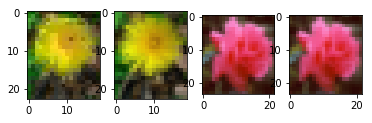

(0, (23, 19, 3))
0.178139925003


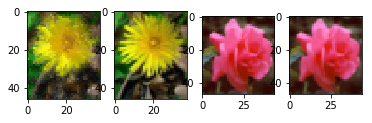

(1, (46, 38, 3))
0.743963956833


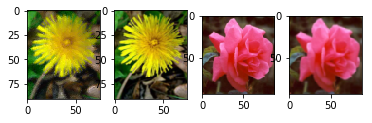

(2, (91, 75, 3))
3.09542608261


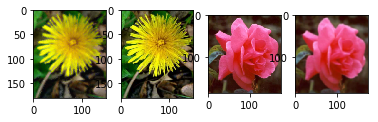

(3, (181, 150, 3))
13.0330519676


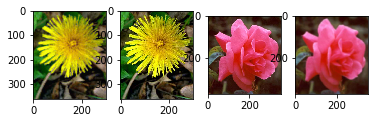

(4, (362, 300, 3))
(362, 300, 3)


In [7]:
kappa = 0.5
print(len(all_feature_src))
L = len(all_feature_src)
for level in range(0, len(all_feature_src)):
    feature1_src = all_feature_src[level]
    feature2_src = getFeature(y_pyramid2_src[level + 1], y_pyramid2_src[level])
    H_src, W_src = feature1_src.shape[:2]
    H_dst, W_dst = feature2_src.shape[:2]
    img2_dst = np.zeros((H_dst, W_dst, 3))
    start = time.time()
    img2_dst = yiq_pyramid2_src[level + 1].copy()
    img1_dst = y_pyramid1_dst[level + 1]
    coef = 1 + 2 ** (level - L) * kappa
    match = np.zeros((H_dst, W_dst, 2), np.int)
    for x2 in range(H_dst):
        for y2 in range(W_dst):
            dis_coh = 1e10
            for dx in range(-2, 1):
                for dy in range(-2, 2):
                    qx, qy = x2 + dx, y2 + dy
                    if qx >= 0 and qy >= 0 and qy < W_dst and (qx < x2 or qy < x2):
                        mx, my = match[qx][qy]
                        tx, ty = mx - dx, my - dy
                        if tx >= 0 and ty >= 0 and tx < img1_dst.shape[0] and ty < img1_dst.shape[1]:
                            feat = feature1_src[tx][ty]
                            dist = np.sum((feat - feature2_src[x2][y2])**2)                            
                            if dis_coh > dist:
                                dis_coh = dist
                                x_coh, y_coh = tx, ty
            idx, dis_app = searchers[level].get_nns_by_vector(feature2_src[x2][y2], 1, include_distances=True)
            idx, dis_app = idx[0], dis_app[0]
            x1, y1 = idx // img1_dst.shape[1], idx % img1_dst.shape[1]
            if dis_coh <= dis_app * coef:
                img2_dst[x2, y2, 0] = img1_dst[x_coh][y_coh]
                match[x2][y2] = np.array([x_coh, y_coh])
            else:
                img2_dst[x2, y2, 0] = img1_dst[x1][y1]
                match[x2][y2] = np.array([x1, y1])
    print(time.time() - start)
    rgb_img2_dst = yiq2rgb(img2_dst)
    rgb_img2_dst = rgb_img2_dst.astype(np.uint8)
    cv2.imwrite('result{}.png'.format(level), rgb_img2_dst)
    plt.subplot(1, 4, 1)
    plt.imshow(rgb_img2_dst[:, :, ::-1])
    plt.subplot(1, 4, 2)
    plt.imshow(pyramid2_src[level+1][:, :, ::-1].astype(np.uint8))
    plt.subplot(1, 4, 3)
    plt.imshow(pyramid1_src[level+1][:, :, ::-1].astype(np.uint8))
    plt.subplot(1, 4, 4)
    plt.imshow(pyramid1_dst[level+1][:, :, ::-1].astype(np.uint8))
    plt.show()
    print(level, pyramid2_src[level + 1].shape)
print(img2_src.shape)